# Dataset description

This dataset captures data over a period of 7 years of how CO2 emissions by a vehicle can vary with the different features.

Features:
- Model

    - 4WD/4X4 = Four-wheel drive
    - AWD = All-wheel drive
    - FFV = Flexible-fuel vehicle
    - SWB = Short wheelbase
    - LWB = Long wheelbase
    - EWB = Extended wheelbase

- Transmission

    - A = Automatic
    - AM = Automated manual
    - AS = Automatic with select shift
    - AV = Continuously variable
    - M = Manual
    - 3 - 10 = Number of gears

- Fuel type

    - X = Regular gasoline
    - Z = Premium gasoline
    - D = Diesel
    - E = Ethanol (E85)
    - N = Natural gas

- Fuel Consumption (L/100 km)

- CO2 Emissions (g/km)

[A video regarding the CO2 emissions across the globe.](https://futurism.com/the-byte/nasa-video-carbon-emissions-visible) Hard watch.

[Latest CO2 global emission levels.](https://www.co2.earth/daily-co2)

> Given these high continual levels (>425 ppm CO2), it would be interesting to see how vehicles impact them.

# Questions

- Determine or test the influence of different variables on the emission of CO2.
- What are the most influencing features that affect the CO2 emission the most?
- Will there be any difference in the CO2 emissions when Fuel Consumption for City and Highway are considered separately and when their weighted variable interaction is considered?

# Data pre-processing and exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

emissions = pd.read_csv("/kaggle/input/co2-emission-by-vehicles/CO2 Emissions_Canada.csv")
emissions.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [2]:
emissions.shape

(7385, 12)

## Check if the combined fuel consumption is well calculated

In [3]:
# extract relevant columns from the dataset
city_consumption = emissions['Fuel Consumption City (L/100 km)']
highway_consumption = emissions['Fuel Consumption Hwy (L/100 km)']
combined_consumption = emissions['Fuel Consumption Comb (L/100 km)']

# combine the city and highway consumption into a matrix
consumption_matrix = np.column_stack([city_consumption, highway_consumption])

consumption_matrix

array([[ 9.9,  6.7],
       [11.2,  7.7],
       [ 6. ,  5.8],
       ...,
       [11.7,  8.6],
       [11.2,  8.3],
       [12.2,  8.7]])

### Linear regression to find coefficients that describe the relationship between city, highway, and combined fuel consumption

The coefficients obtained from the linear regression represent the "amounts" or "weights" (importance factors) of city and highway fuel consumption that contribute to the combined fuel consumption.

> For instance, if the coefficient for city fuel consumption is 0.3, i.e. for every unit increase in city fuel consumption, the combined fuel consumption is expected to increase by 0.3 units.

- used "least squares" method from the linear algebra numpy module (np.linalg) - typically used in linear regression to find the best-fitting line through a set of data points; thus, minimizing the sum of squared differences between the predicted and actual values
- this returns a *tuple of 4 values*, reason being for tuple unpacking

In [4]:
# linear regression to find the relationship between city, highway, and combined consumption
# tuple unpacking; we're interested in the first value (the coeff) and the rest are ignored
coefficients, _, _, _ = np.linalg.lstsq(consumption_matrix, combined_consumption, rcond = None)

coefficients

array([0.54977202, 0.45035134])

- axis = 0 parameter below specifies that the averaging operation is performed along the rows i.e. for each column (feature), the weighted average is calculated (independently) across the rows

In [5]:
# calculate the weighted average of city and highway consumption using the obtained coefficients
weighted_avg = np.round(np.average([city_consumption, highway_consumption], weights = coefficients, axis = 0), 1)

# print calculated coefficients and compare with the actual combined consumption for the first five rows
print('Coefficients:', coefficients)
print('Weighted Average:', weighted_avg[:10])
print('Actual Combined Consumption:', list(combined_consumption.iloc[:10]))

# absolute difference between the actual and calculated combined consumption
difference = np.abs(combined_consumption - weighted_avg)

# average and maximum absolute difference
print('The average difference is:', np.round(np.average(difference), 3), '(L/100 km)')
print('The max difference is:', np.max(difference), '(L/100 km)')

Coefficients: [0.54977202 0.45035134]
Weighted Average: [ 8.5  9.6  5.9 11.1 10.6 10.  10.1 11.1 11.6  9.2]
Actual Combined Consumption: [8.5, 9.6, 5.9, 11.1, 10.6, 10.0, 10.1, 11.1, 11.6, 9.2]
The average difference is: 0.017 (L/100 km)
The max difference is: 0.5 (L/100 km)


- the first coefficient (0.54977202) corresponds to city fuel consumption
- the second coefficient (0.45035134) corresponds to highway fuel consumption
- they indicate the contribution of each feature to the prediction of the combined fuel consumption
- each value in the weighted average array corresponds to a predicted combined fuel consumption for the corresponding data point
- the average difference represents the average absolute difference between the predicted (weighted average) and actual values of combined fuel consumption across all data points, which in this case is pretty low

> To sum up, the discrepancies seem relatively low, especially considering the average difference. 

The calculations for the "Fuel Consumption Comb (mpg)" seem off since, since the conversion between miles per gallon (mpg) and liters per 100 kilometers (L/100 km) is given by the formula:

mpg = $\frac{235.215}{L/100 \, \text{km}}$

Therefore, for 8.5 L/100km we would have 27.67 mpg, instead of 33. This is why we will drop this column and only use the one in L/100km. 


In [6]:
emissions = emissions.drop('Fuel Consumption Comb (mpg)', axis = 1)

### Check for missing data and percentages

In [7]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum() / data.count() * 100).sort_values(ascending = False)
    
    return pd.concat([total, percent], axis = 1, keys = ['Total values missing', 'Percent of data missing'])

missing_data(emissions)

,Total values missing,Percent of data missing
Make,0,0.0
Model,0,0.0
Vehicle Class,0,0.0
Engine Size(L),0,0.0
Cylinders,0,0.0
Transmission,0,0.0
Fuel Type,0,0.0
Fuel Consumption City (L/100 km),0,0.0
Fuel Consumption Hwy (L/100 km),0,0.0
Fuel Consumption Comb (L/100 km),0,0.0


In [8]:
emissions.describe()

,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),CO2 Emissions(g/km)
count,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000,7385.000000
mean,3.160068,5.615030,12.556534,9.041706,10.975071,250.584699
std,1.354170,1.828307,3.500274,2.224456,2.892506,58.512679
min,0.900000,3.000000,4.200000,4.000000,4.100000,96.000000
25%,2.000000,4.000000,10.100000,7.500000,8.900000,208.000000
50%,3.000000,6.000000,12.100000,8.700000,10.600000,246.000000
75%,3.700000,6.000000,14.600000,10.200000,12.600000,288.000000
max,8.400000,16.000000,30.600000,20.600000,26.100000,522.000000


- The mean for CO2 emissions is 250 g/km
- No matter the parameter, Fuel Consumption Hwy (L/100 km) < Fuel Consumption Comb (L/100 km)

## Check for duplicated data

In [9]:
emissions_duplicated = emissions[emissions.duplicated() == True]
emissions_duplicated

#emissions.duplicated().sum()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),CO2 Emissions(g/km)
1075,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,244
1076,ACURA,RLX,MID-SIZE,3.5,6,AS6,Z,11.9,7.7,10.0,230
1081,ALFA ROMEO,4C,TWO-SEATER,1.8,4,AM6,Z,9.7,6.9,8.4,193
1082,ASTON MARTIN,DB9,MINICOMPACT,5.9,12,A6,Z,18.0,12.6,15.6,359
1084,ASTON MARTIN,V8 VANTAGE,TWO-SEATER,4.7,8,AM7,Z,17.4,11.3,14.7,338
...,...,...,...,...,...,...,...,...,...,...,...
7356,TOYOTA,Tundra,PICKUP TRUCK - STANDARD,5.7,8,AS6,X,17.7,13.6,15.9,371
7365,VOLKSWAGEN,Golf GTI,COMPACT,2.0,4,M6,X,9.8,7.3,8.7,203
7366,VOLKSWAGEN,Jetta,COMPACT,1.4,4,AS8,X,7.8,5.9,7.0,162
7367,VOLKSWAGEN,Jetta,COMPACT,1.4,4,M6,X,7.9,5.9,7.0,163


In [10]:
emissions.shape

(7385, 11)

There is almost 15% of duplicates, which I think it is quite much. 
Let's see the number of unique values of 'CO2 Emissions(g/km)' for each combination of the specified columns.

In [11]:
sum(emissions_duplicated.groupby(by =['Make','Model','Vehicle Class','Engine Size(L)','Cylinders','Transmission','Fuel Type'])['CO2 Emissions(g/km)'].nunique())

998

I will consider the duplicates as instances that happen to have the same values instead of dropping them, since I don't think they will impact the results.

# Data visualization

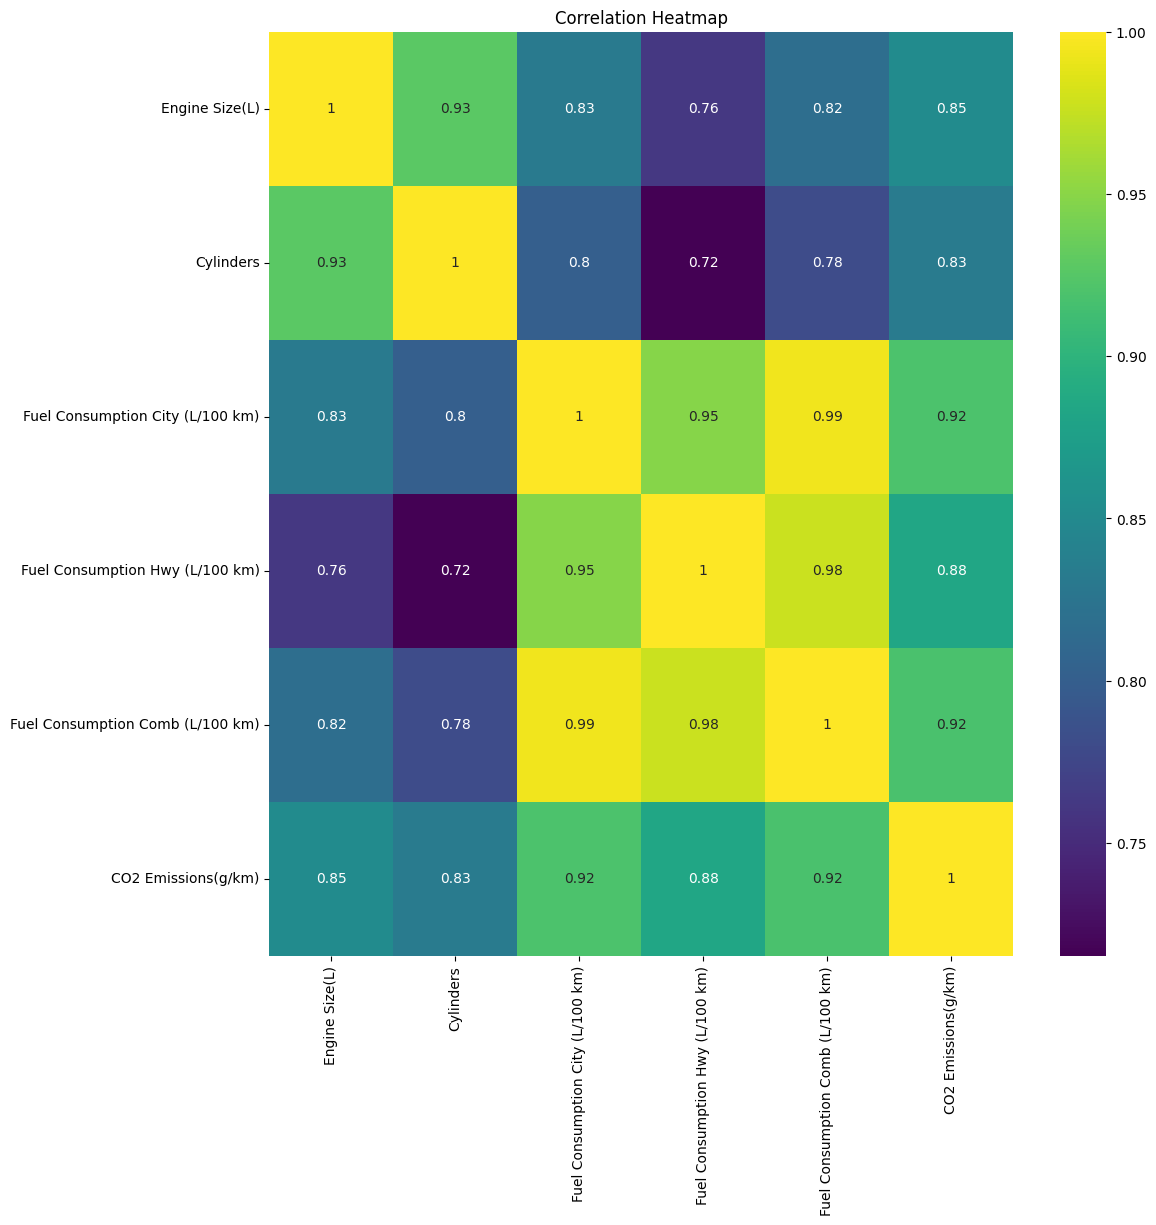

In [12]:
# heatmap to see the correlations between numeric values
numeric_columns = emissions.select_dtypes(include=['number'])

correlation_matrix = numeric_columns.corr()
plt.figure(figsize = (12, 12))
sns.heatmap(correlation_matrix, cmap = 'viridis', annot = True)
plt.title('Correlation Heatmap')
plt.show()

- All features impact negatively the CO2 emissions, especially the fuel consumption and the engine size; plus, the higher the number of cylinders, the higher the engine size.

In [13]:
# statistics for columns with object (string) data types

emissions.describe(include=['O'])

,Make,Model,Vehicle Class,Transmission,Fuel Type
count,7385,7385,7385,7385,7385
unique,42,2053,16,27,5
top,FORD,F-150 FFV 4X4,SUV - SMALL,AS6,X
freq,628,32,1217,1324,3637


## Normality

Since Linear regression assumes that the residuals (the differences between the observed and predicted values) are normally distributed, I will check if the data is normally distributed.


> Box plots to visually represent the distribution of data and highlight potential outliers (points beyond the "whiskers" of the box plot are considered outliers),

In [14]:
emissions.isnull().sum().any()

False

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


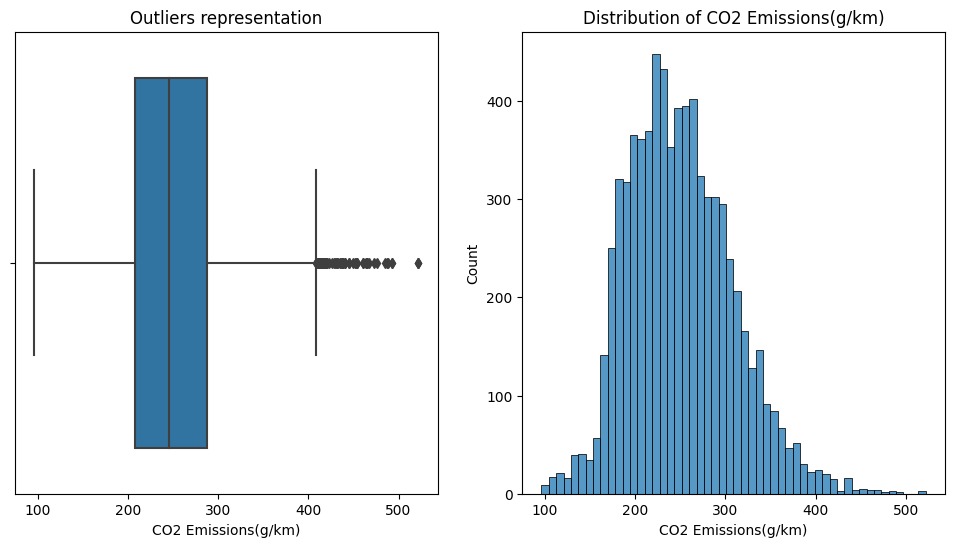

In [15]:
# box plot for CO2 emissions 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot number 1
sns.boxplot(x = emissions['CO2 Emissions(g/km)'])
plt.title('Outliers representation')

# histplot for normal distribution of the CO2 values
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot no. 2
sns.histplot(x = emissions['CO2 Emissions(g/km)'])
plt.title('Distribution of CO2 Emissions(g/km)')
plt.show()

- There seem to be some outliers and the data seems normally distributed, slightly skewed to the left.

## Remove outliers

I will calculate the z-score for each data point, where the z-score indicates how many standard deviations a data point is from the mean. 

In [16]:
from scipy import stats

z_scores = stats.zscore(emissions['CO2 Emissions(g/km)'])
# select rows where absolute Z-score is less than 3
emissions = emissions[abs(z_scores) < 2.6]

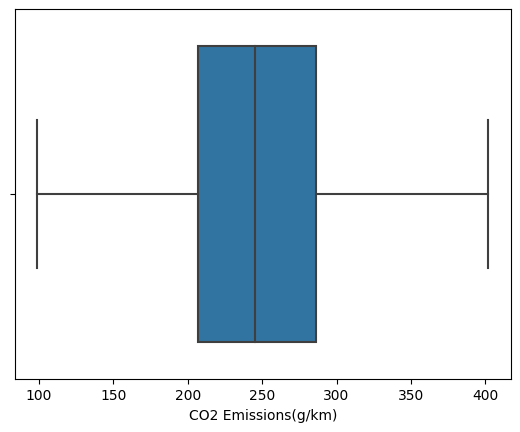

In [17]:
sns.boxplot(x = emissions['CO2 Emissions(g/km)'])
plt.show()

- Outliers removed. Let's look at the data distribution again.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


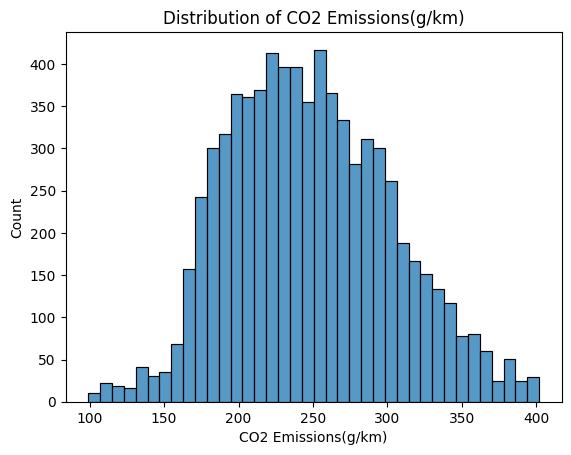

In [18]:
sns.histplot(x = emissions['CO2 Emissions(g/km)'])
plt.title('Distribution of CO2 Emissions(g/km)')
plt.show()

- Now, the data is normally distributed around the mean (250).

## CO2 emissions on average by vehicle model

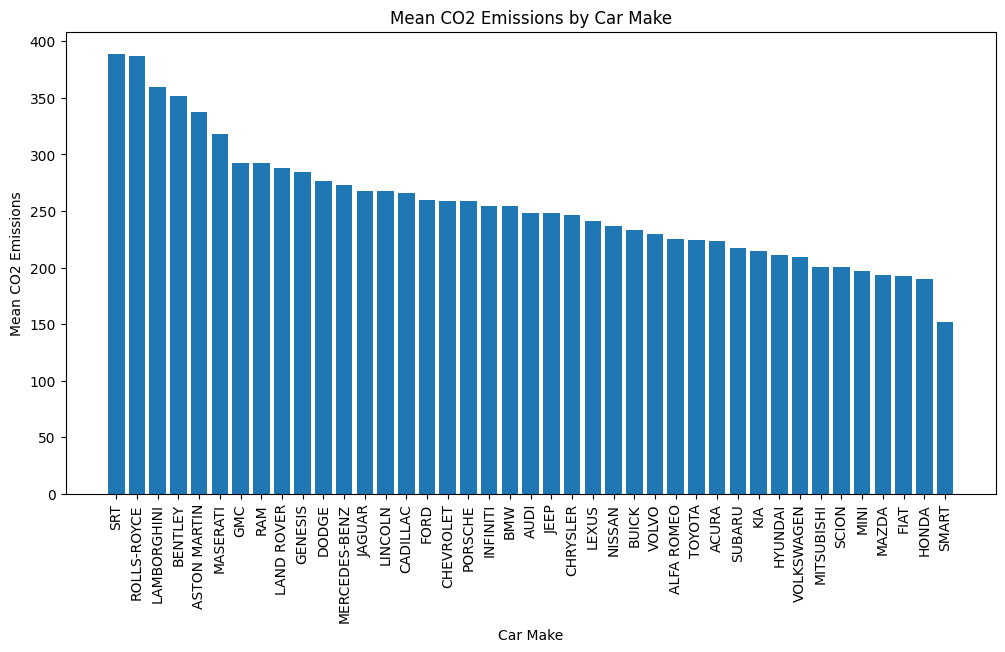

In [19]:
plt.figure(figsize = (12, 6))
mean_emissions_by_make = emissions.groupby('Make')['CO2 Emissions(g/km)'].mean().sort_values(ascending=False)
plt.bar(mean_emissions_by_make.index, mean_emissions_by_make) # the indexes are the unique car makes 
plt.title("Mean CO2 Emissions by Car Make")
plt.xlabel("Car Make")
plt.ylabel("Mean CO2 Emissions")
plt.xticks(rotation = 90)  # rotate x-axis labels 
plt.show()

- What about the number of cars each company registered in this dataset?

In [20]:
emissions['Make'].nunique()

41

- There are 41 companies in the dataset. I will make a bar plot with all of them, in ascending order by the number of cars each has produced and registered here.

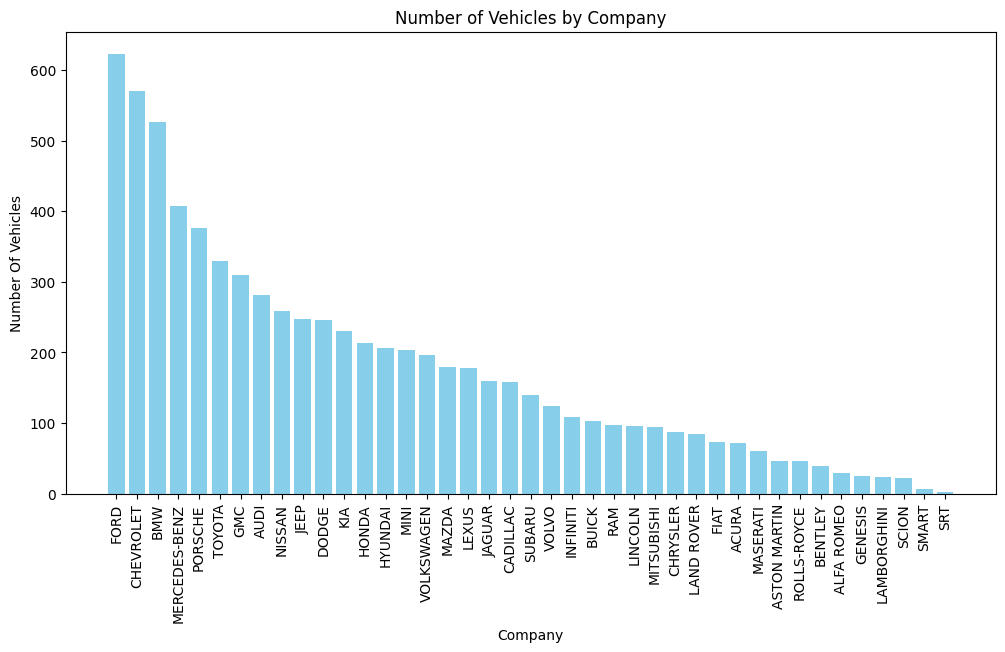

In [21]:
emissions_make = emissions['Make'].value_counts()

# Create a bar plot for all unique companies
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
plt.bar(emissions_make.index, emissions_make, color = 'skyblue')

plt.title('Number of Vehicles by Company')
plt.xlabel('Company')
plt.ylabel('Number Of Vehicles')
plt.xticks(rotation = 90)  
plt.show()

- Data is somehow scattered and for instance, even though Ford has the highest number of cars in this dataset, it falls in the middle regarding the average CO2 emissions. However, 600 cars * 270 g/km is a pretty high number indicating the CO2 emissions. 

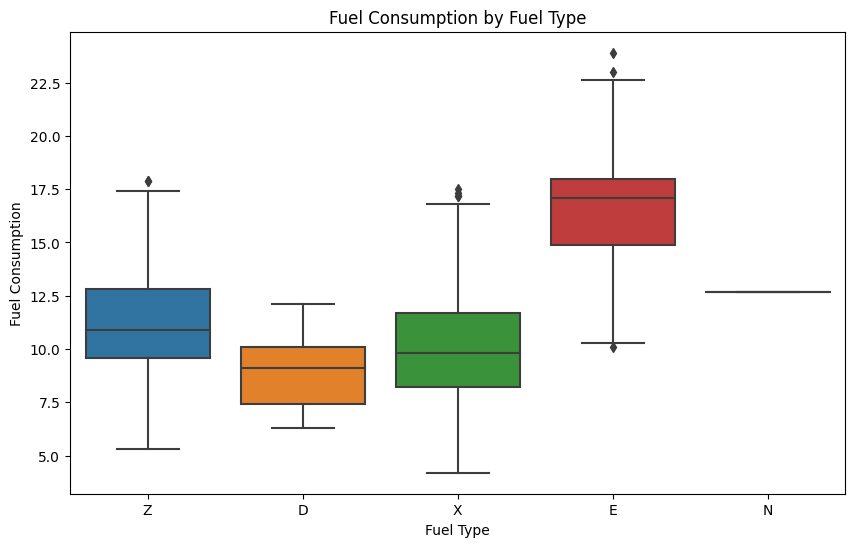

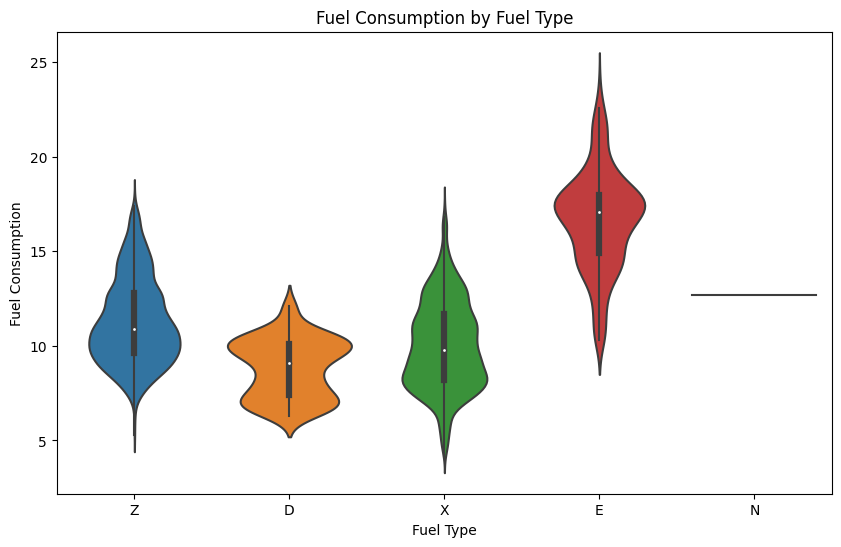

In [22]:
plt.figure(figsize = (10, 6))

# box plot
sns.boxplot(x = 'Fuel Type', y = 'Fuel Consumption Comb (L/100 km)', data = emissions)
plt.title('Fuel Consumption by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Fuel Consumption')
plt.show()

# violin plot
plt.figure(figsize = (10, 6))
sns.violinplot(x = 'Fuel Type', y = 'Fuel Consumption Comb (L/100 km)', data = emissions)
plt.title('Fuel Consumption by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Fuel Consumption')
plt.show()

In [23]:
emissions.shape

(7289, 11)

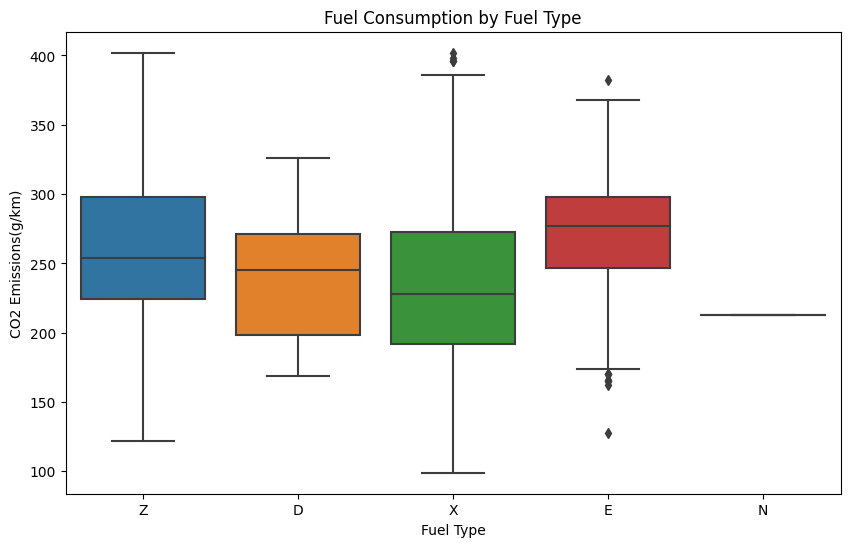

In [24]:
plt.figure(figsize = (10, 6))

# box plot
sns.boxplot(x = 'Fuel Type', y = 'CO2 Emissions(g/km)', data = emissions)
plt.title('Fuel Consumption by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('CO2 Emissions(g/km)')
plt.show()